<a href="https://colab.research.google.com/github/geoskimoto/SNOTEL_DoubleMassAnalysis/blob/fix_root/SiteCharacterization02_05_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To Do's

*   Convert years to water year
*   Add option to color code each year/make each year a different series
*   Add function comparing descriptive statistics in n yr blocks.  
*   If time, eigendecompose/create cov matrix for each year and compare descrip stats of eigenvectors 



### Library imports

In [349]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import statsmodels.api as sm
from functools import reduce

In [350]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/My Drive/Projects/Work/SiteComparisons/Data

/content/gdrive/My Drive/Projects/Work/SiteComparisons/Data


In [4]:
ls

Data_parsing.ipynb     OR_1991-2021.xlsx      WA_1991-2021.xlsx
OR_1991-2021_raw.xlsx  WA_1991-2001_raw.xlsx


### Data Import and Prep

In [351]:
WA_Sites = pd.read_excel('WA_1991-2021.xlsx')
# pd.to_datetime(WA_Sites['Date'])
WA_Sites.set_index('Date',inplace=True)
# WA_Sites.sample(5)

OR_Sites = pd.read_excel('OR_1991-2021.xlsx')
# pd.to_datetime(OR_Sites['Date'])
OR_Sites.set_index('Date',inplace=True)
# OR_Sites.sample(5)

ORWA_Sites = pd.merge(OR_Sites,WA_Sites,left_index=True,right_index=True)
ORWA_Sites.head(1)

,Aneroid Lake #2 (302) Air Temperature Average (degF),Aneroid Lake #2 (302) Precipitation Accumulation (in) Start of Day Values,Aneroid Lake #2 (302) Snow Water Equivalent (in) Start of Day Values,Annie Springs (1000) Air Temperature Average (degF),Annie Springs (1000) Precipitation Accumulation (in) Start of Day Values,Annie Springs (1000) Snow Water Equivalent (in) Start of Day Values,Anthony Lake (1245) Air Temperature Average (degF),Anthony Lake (1245) Precipitation Accumulation (in) Start of Day Values,Anthony Lake (1245) Snow Water Equivalent (in) Start of Day Values,Arbuckle Mtn (304) Air Temperature Average (degF),Arbuckle Mtn (304) Precipitation Accumulation (in) Start of Day Values,Arbuckle Mtn (304) Snow Water Equivalent (in) Start of Day Values,Bald Mtn AM OR (447) Air Temperature Average (degF),Bald Mtn AM OR (447) Precipitation Accumulation (in) Start of Day Values,Bald Mtn AM OR (447) Snow Water Equivalent (in) Start of Day Values,Barney Creek (1246) Air Temperature Average (degF),Barney Creek (1246) Precipitation Accumulation (in) Start of Day Values,Barney Creek (1246) Snow Water Equivalent (in) Start of Day Values,Bear Flat Meadow AM (1291) Air Temperature Average (degF),Bear Flat Meadow AM (1291) Precipitation Accumulation (in) Start of Day Values,Bear Flat Meadow AM (1291) Snow Water Equivalent (in) Start of Day Values,Bear Grass (1166) Air Temperature Average (degF),Bear Grass (1166) Precipitation Accumulation (in) Start of Day Values,Bear Grass (1166) Snow Water Equivalent (in) Start of Day Values,Beaver Reservoir (331) Air Temperature Average (degF),Beaver Reservoir (331) Precipitation Accumulation (in) Start of Day Values,Beaver Reservoir (331) Snow Water Equivalent (in) Start of Day Values,Big Red Mountain (341) Air Temperature Average (degF),Big Red Mountain (341) Precipitation Accumulation (in) Start of Day Values,Big Red Mountain (341) Snow Water Equivalent (in) Start of Day Values,Big Sheep AM (1229) Air Temperature Average (degF),Big Sheep AM (1229) Precipitation Accumulation (in) Start of Day Values,Big Sheep AM (1229) Snow Water Equivalent (in) Start of Day Values,Bigelow Camp (343) Air Temperature Average (degF),Bigelow Camp (343) Precipitation Accumulation (in) Start of Day Values,Bigelow Camp (343) Snow Water Equivalent (in) Start of Day Values,Billie Creek Divide (344) Air Temperature Average (degF),Billie Creek Divide (344) Precipitation Accumulation (in) Start of Day Values,Billie Creek Divide (344) Snow Water Equivalent (in) Start of Day Values,Blazed Alder (351) Air Temperature Average (degF),...,Stampede Pass (788) Snow Water Equivalent (in) Start of Day Values,Stevens Pass (791) Air Temperature Average (degF),Stevens Pass (791) Precipitation Accumulation (in) Start of Day Values,Stevens Pass (791) Snow Water Equivalent (in) Start of Day Values,Surprise Lakes (804) Air Temperature Average (degF),Surprise Lakes (804) Precipitation Accumulation (in) Start of Day Values,Surprise Lakes (804) Snow Water Equivalent (in) Start of Day Values,Swamp Creek (975) Air Temperature Average (degF),Swamp Creek (975) Precipitation Accumulation (in) Start of Day Values,Swamp Creek (975) Snow Water Equivalent (in) Start of Day Values,Swift Creek (1012) Air Temperature Average (degF),Swift Creek (1012) Precipitation Accumulation (in) Start of Day Values,Swift Creek (1012) Snow Water Equivalent (in) Start of Day Values,Thunder Basin (817) Air Temperature Average (degF),Thunder Basin (817) Precipitation Accumulation (in) Start of Day Values,Thunder Basin (817) Snow Water Equivalent (in) Start of Day Values,Tinkham Creek (899) Air Temperature Average (degF),Tinkham Creek (899) Precipitation Accumulation (in) Start of Day Values,Tinkham Creek (899) Snow Water Equivalent (in) Start of Day Values,Touchet (824) Air Temperature Average (degF),Touchet (824) Precipitation Accumulation (in) Start of Day Values,Touchet (824) Snow Water Equivalent (in) Start of Day Values,Trinity (1171) Air Temperature Average (degF),Tr

In [12]:
# ORWA_Sites2.columns[-50:]

In [352]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html

ORWA_AirTemp = ORWA_Sites[ORWA_Sites.columns[::3]]
stations = [ORWA_AirTemp.columns[i].rsplit(' ', 4)[0] for i in range(0, len(ORWA_AirTemp.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["AirTemp (degF)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_AirTemp.columns = header

ORWA_Precip = ORWA_Sites[ORWA_Sites.columns[1::3]]
stations = [ORWA_Precip.columns[i].rsplit(' ', 7)[0] for i in range(0, len(ORWA_Precip.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["Precip (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_Precip.columns = header
# ORWA_Precip.columns = stations

ORWA_SWE = ORWA_Sites[ORWA_Sites.columns[2::3]]
stations = [ORWA_SWE.columns[i].rsplit(' ', 8)[0] for i in range(0, len(ORWA_SWE.columns))]  #probably not the cleanest way to extract station name, but hey it works.
iterables = [stations, ["SWE (in)"]]
header = pd.MultiIndex.from_product(iterables, names=["station", "parameter"])
ORWA_SWE.columns = header
# ORWA_SWE.columns = stations

ORWA_Sites2 = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), [ORWA_AirTemp,ORWA_Precip,ORWA_SWE])
ORWA_Sites2.head(1)


station,Aneroid Lake #2 (302),Annie Springs (1000),Anthony Lake (1245),Arbuckle Mtn (304),Bald Mtn AM OR (447),Barney Creek (1246),Bear Flat Meadow AM (1291),Bear Grass (1166),Beaver Reservoir (331),Big Red Mountain (341),Big Sheep AM (1229),Bigelow Camp (343),Billie Creek Divide (344),Blazed Alder (351),Blue Mountain Spring (357),Bourne (361),Bowman Springs (362),Buckskin Lake AM (1292),Call Meadows AM (1289),Cascade Summit (388),Chemult Alternate (395),Clackamas Lake (398),Clear Lake (401),Cold Springs Camp (406),County Line (422),Cox Flat AM (1273),Crazyman Flat (1010),Daly Lake (434),Derr. (440),Diamond Lake (442),Eilertson Meadows (464),Emigrant Springs (470),Finley Corrals AM (1274),Fish Creek (477),Fish Lk. (479),Fourmile Lake (483),Gerber Reservoir (945),Gold Center (494),Government Corrals (1250),Greenpoint (504),...,Mowich (941),Mt. Tebo (1126),Muckamuck (1259),Olallie Meadows (672),Paradise (679),Park Creek Ridge (681),Pepper Creek (1104),Pigtail Peak (692),Pinto Rock (1263),Pope Ridge (699),Potato Hill (702),Quartz Peak (707),Rainy Pass (711),Rex River (911),Salmon Meadows (728),Sasse Ridge (734),Satus Pass (1231),Sawmill Ridge (1068),Sentinel Butte (1043),Sheep Canyon (748),Skate Creek (1257),Skookum Creek (912),Sourdough Gulch (985),Spencer Meadow (776),Spirit Lake (777),Spruce Springs (984),Stampede Pass (788),Stevens Pass (791),Surprise Lakes (804),Swamp Creek (975),Swift Creek (1012),Thunder Basin (817),Tinkham Creek (899),Touchet (824),Trinity (1171),Trough (832),Upper Wheeler (841),Waterhole (974),Wells Creek (909),White Pass E.S. (863)
parameter,AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),...,SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1991-01-01,24.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,22.0,36.0,NaN,39.0,25.0,NaN,22.0,25.0,22.0,NaN,NaN,29.0,19.0,25.0,25.0,28.0,24.0,NaN,NaN,31.0,NaN,25.0,12.0,26.0,NaN,28.0,22.0,33.0,NaN,22.0,NaN,31.0,...,NaN,NaN,NaN,19.8,32.7,28.4,NaN,28.6,NaN,7.5,9.5,7.1,28.4,NaN,3.1,10.6,NaN,NaN,NaN,18.9,NaN,NaN,NaN,9.4,3.9,NaN,18.7,20.9,18.6,NaN,NaN,19.5,NaN,9.9,NaN,1.7,4.7,NaN,NaN,9.1


### Exploratory Analysis

#### Take a look at NaN/missing values

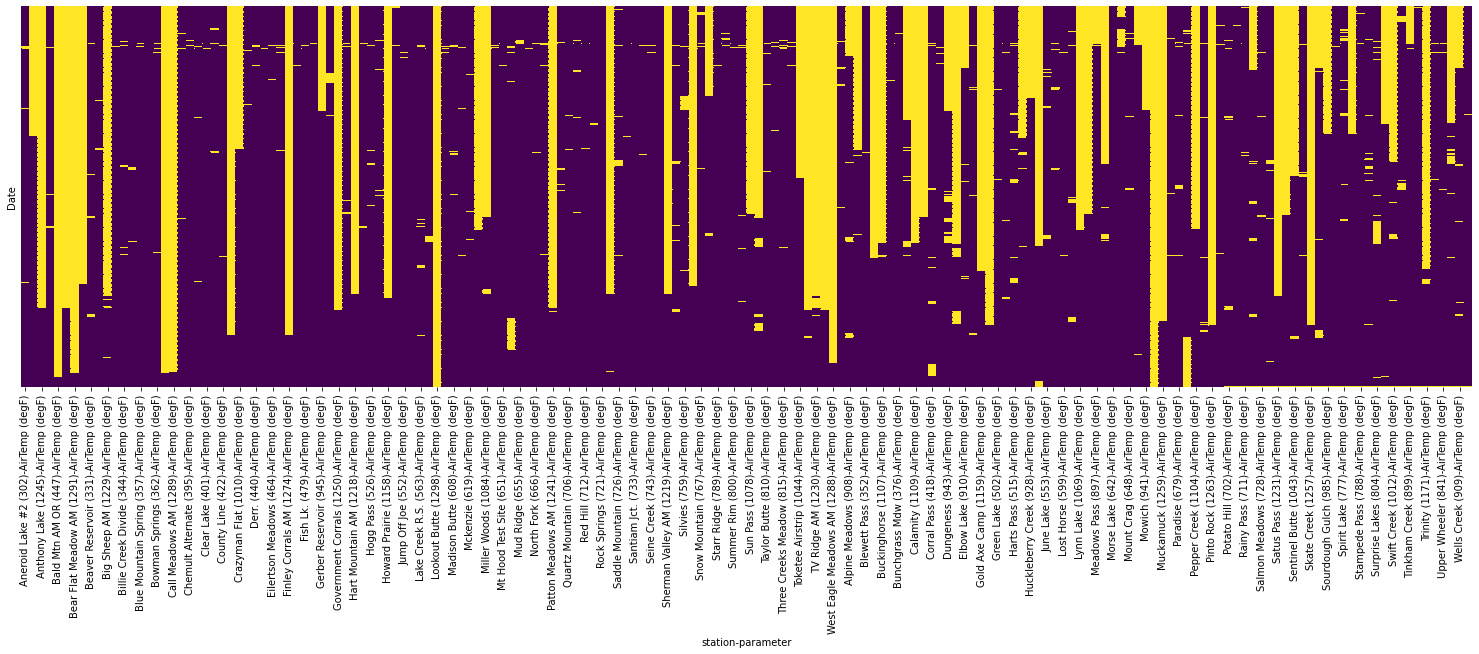

In [ ]:
#Heatmap of missing data.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,7))
sns.heatmap(ORWA_AirTemp.isnull(),yticklabels=False,cbar=False,cmap='viridis')

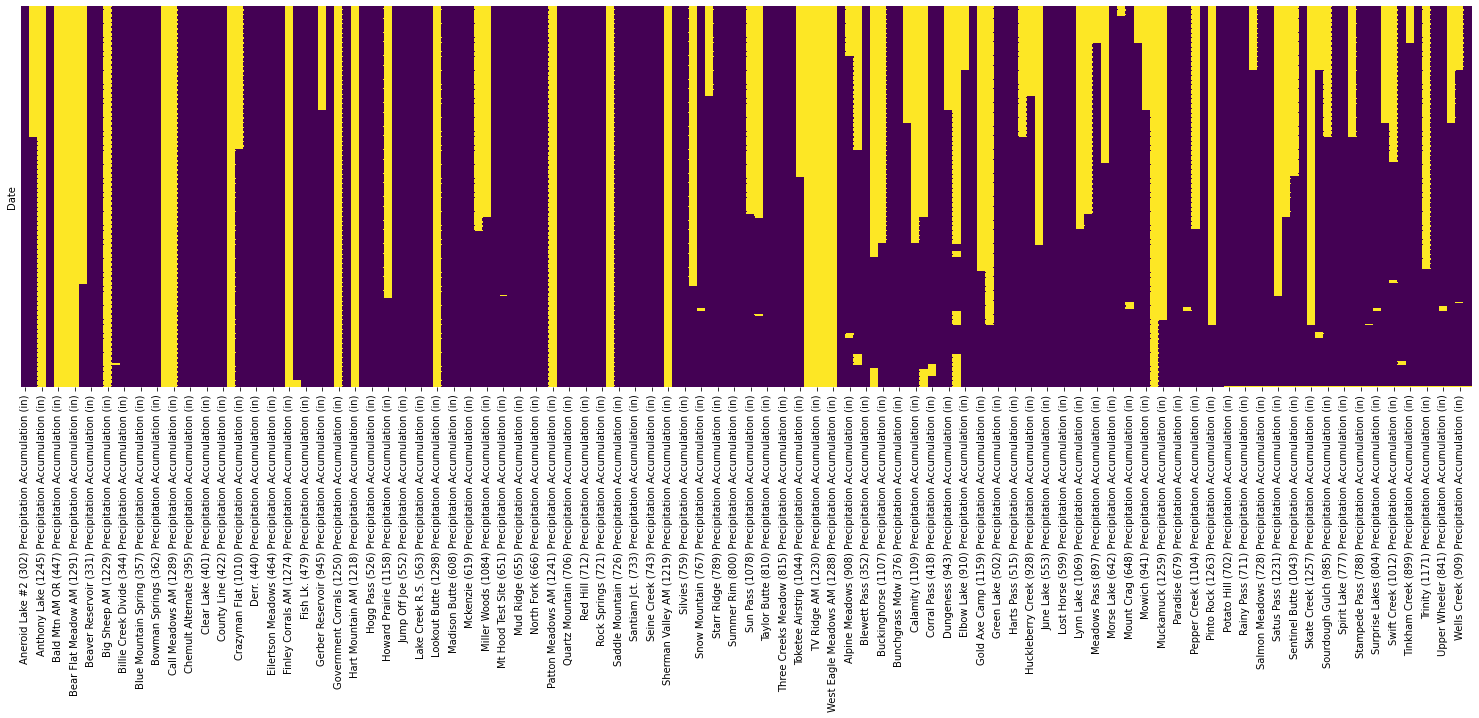

In [ ]:
#Heatmap of missing data.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,7))
sns.heatmap(ORWA_Precip.isnull(),yticklabels=False,cbar=False,cmap='viridis')

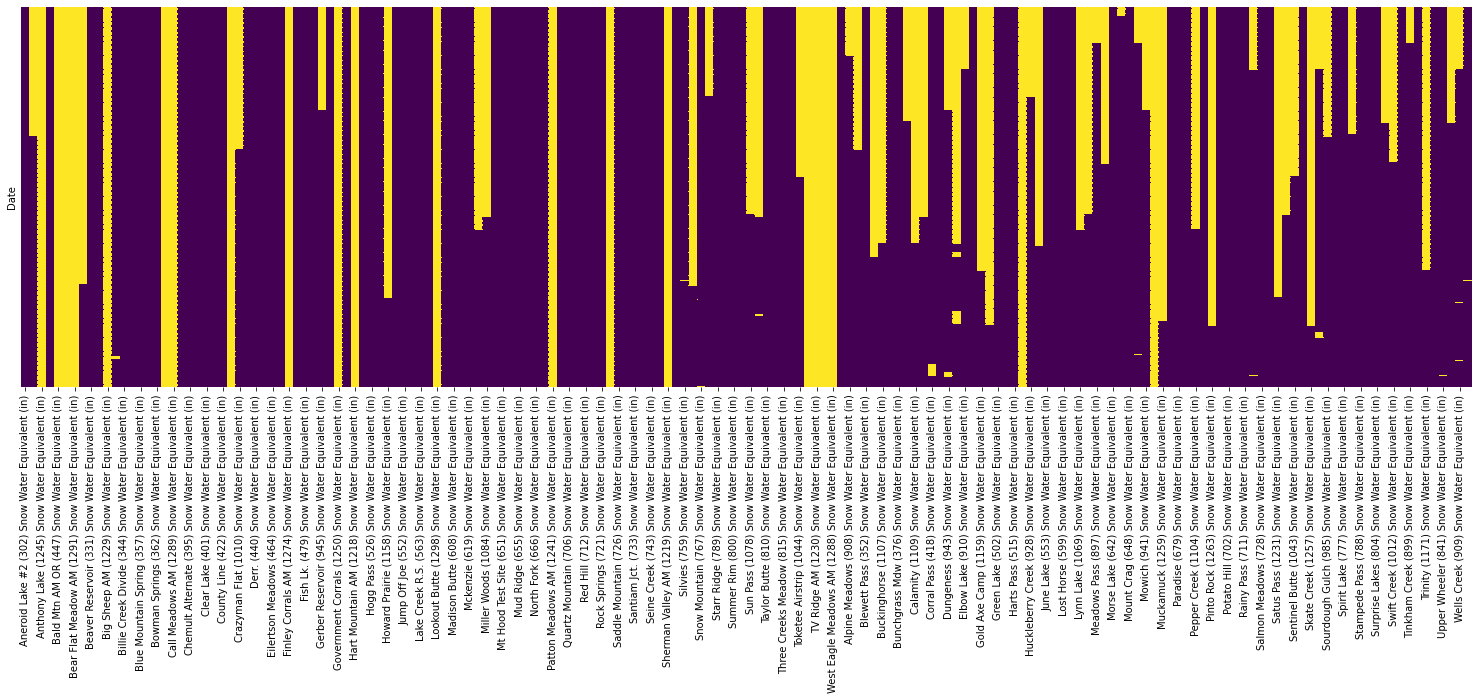

In [ ]:
#Heatmap of missing data.  Yellow = nulls.
fig, ax = plt.subplots(1, figsize=(26,7))
sns.heatmap(ORWA_WTEQ.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Procedural function building

In [ ]:
args = ('Billie Creek Divide (344)', 'Blazed Alder (351)',	'Blue Mountain Spring (357)')
time_freq = 'D'
site_list = [ORWA_Sites2[args[i]]['SWE (in)'].dropna().resample(time_freq).sum() for i in range(0, len(args))] 
df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
df2 = df_merged.resample(time_freq).sum()

# df2.columns = [f'{args[0]} SWE (in)', f'{args[1]} SWE (in)', f'{args[2]} SWE (in)']
df2.columns = [f'{args[i]} SWE (in)' for i in range(0, len(args))]


In [ ]:
years = list(range(1991, 2020))
yr = [df2[str(years[i])] for i in range(0,len(years))]  

# [df2[year] for year in range(0,)]

In [ ]:
#SINGLE
x=pd.DataFrame(yr[0].iloc[:,0].cumsum())
x.columns = ['x']
y=pd.DataFrame(np.add.reduce([yr[0].iloc[:,i].cumsum() for i in range(0, len(args))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
y.index = x.index
y.columns= ['y']


In [ ]:
#SINGLE USING pd.apply(func)
cummulative_sum = pd.DataFrame(yr[0].apply(np.cumsum))   
x = pd.DataFrame(cummulative_sum.iloc[:,0])
y = pd.DataFrame(np.sum(cummulative_sum, axis=1))
y.columns= ['reduced_cumsum']

In [ ]:
#ITERATIVE USING pd.apply(func)
cummulative_sum = [yr[i].apply(np.cumsum) for i in range(0,len(years))]
x = [pd.DataFrame(cummulative_sum[i].iloc[:,0]) for i in range(0,len(years))]
y = [pd.DataFrame(np.sum(cummulative_sum[i], axis=1)) for i in range(0,len(years))]

for i in range(0,len(years)):
  y[i].columns = ['reduced_cumsum']

In [ ]:
#ITERATIVE PLOTS
fig = go.Figure()

# for i in range(0,len(years)):
#   customdata_list[i] = pd.join()

# customdata_list = [df2.iloc[:,0], x, y]
# customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
# customdata.reset_index(inplace=True)

for i in range(0,len(years)):
  fig.add_trace(go.Scatter(
    x=x[i].iloc[:,0],
    y=y[i].iloc[:,0],
    mode='lines',
    name=f'{x[i].index[0].strftime("%Y")}',
    hovertext = x[i].index

))

fig.show()

In [ ]:
#COMBINING IT ALL TOGETHER
args = ('Billie Creek Divide (344)', 'Blazed Alder (351)',	'Blue Mountain Spring (357)')
time_freq = 'D'
parameter = 'SWE (in)'
site_list = [ORWA_Sites2[args[i]][parameter].dropna().resample(time_freq).sum() for i in range(0, len(args))] 
df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
df2 = df_merged.resample(time_freq).sum()

# df2.columns = [f'{args[0]} SWE (in)', f'{args[1]} SWE (in)', f'{args[2]} SWE (in)']
df2.columns = [f'{args[i]} {parameter}' for i in range(0, len(args))]
print(df2.index[0].strftime("%Y"))

years = list(range(int(df2.index[0].strftime("%Y")), int(df2.index[-1].strftime("%Y"))))
yr = [df2[str(years[i])] for i in range(0,len(years))]

cummulative_sum = [yr[i].apply(np.cumsum) for i in range(0,len(years))]
x = [pd.DataFrame(cummulative_sum[i].iloc[:,0]) for i in range(0,len(years))]
y = [pd.DataFrame(np.sum(cummulative_sum[i], axis=1)) for i in range(0,len(years))]

for i in range(0,len(years)):
  y[i].columns = ['reduced_cumsum']

for i in range(0,len(years)):
  fig.add_trace(go.Scatter(
    x=x[i].iloc[:,0],
    y=y[i].iloc[:,0],
    mode='lines',
    name=f'{x[i].index[0].strftime("%Y")}',
    hovertext = x[i].index,
    
))

fig.show()

1991


### Outlier detection using box plots

In [ ]:
# params = ['AirTemp (degF)', 'SWE (in)', 'Precip (in)']
# # for i in range(0,3):
# bla = [ORWA_Sites2['Aneroid Lake #2 (302)'][params[i]] for i in range(0,3)]

In [ ]:
def boxplots(station, data_pt_type):

  params = ['AirTemp (degF)', 'SWE (in)', 'Precip (in)']

  df = [ORWA_Sites2[station][params[i]] for i in range(0,3)]

  fig = go.Figure()
  for i in range(0,3):
  #   WA = WA_Sites[WA_Sites[i] != 0].dropna()

    fig.add_trace(go.Box(y = df[i], 
            name = params[i],
            boxpoints=data_pt_type, #options include: 'all', 'outliers','suspectedoutliers'
            hovertext = df[i].index,
            jitter=0.2,
            whiskerwidth=0.5                
    ))

  fig.update_layout(
          autosize=False,
          width=1200,
          height=500,
          margin=dict(l=20, r=20, t=2, b=8),
          paper_bgcolor="LightSteelBlue",
          title={
          'text': f'{station}',
          'y':0.98,
          'x':0.45,
          'xanchor': 'center',
          'yanchor': 'top'
          }
  )

  fig.show()

In [ ]:
boxplots('Aneroid Lake #2 (302)', data_pt_type='suspectedoutliers')

### Outlier detection and data gap tool using regression

In [ ]:
# df = ORWA_Sites2[['Corral Pass (418)','Pigtail Peak (692)']]
# df2 = pd.merge(df['Corral Pass (418)']['SWE (in)'], df['Pigtail Peak (692)']['SWE (in)'], left_on='Date', right_on="Date").dropna()
# df2
# Pigtail Peak (692)

In [ ]:
# type(df2['SWE (in)_x'])
# type(np.array(df2['SWE (in)_x']).reshape(-1, 1))
# np.array(df2['SWE (in)_x']).reshape(-1, 1)
# X = np.array(df2['SWE (in)_x']).reshape((-1, 1))


pandas.core.series.Series

In [ ]:
df = pd.merge(ORWA_Sites2['Corral Pass (418)']['SWE (in)'], ORWA_Sites2['Pigtail Peak (692)']['SWE (in)'], left_on='Date', right_on="Date").dropna()

X = np.array(df['SWE (in)_x']).reshape(-1, 1)  
y = np.array(df['SWE (in)_y']) #.squeeze()

#LassoCV has built-in cross-validation to figure out the best alpha/regulizer value.  
#Just have to provide the alphas for it to run.  Default is (0.1,1,10).  Crazy simple.
model = LassoCV(alphas=(0.001,0.01,0.1,1,10,100,1000)).fit(X,y)
# model = LinearRegression().fit(X, y) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

In [ ]:
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

coefficient of determination: 0.9654944604834336
slope: [1.55448013]
intercept: -0.4571027759898634


In [ ]:
y_pred = model.predict(X_test)

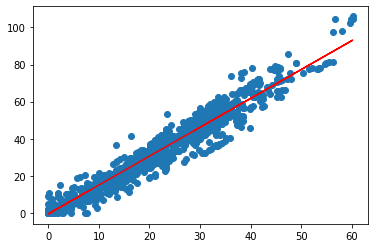

In [ ]:
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, '-r')

# pd.DataFrame(y_pred).plot()
# pd.DataFrame(y_test).plot()

In [ ]:
y_pred

array([-0.45710278, 24.57002737, 53.32790984, ..., -0.45710278,
       33.11966811, 46.9545413 ])

In [ ]:
y_test

array([ 0. , 15.3, 38.2, ...,  0. , 35.8, 46.5])

### Double Mass Functions

#### Selecting top correlated station to run double mass

In [218]:
ORWA_Sites2

station,Aneroid Lake #2 (302),Annie Springs (1000),Anthony Lake (1245),Arbuckle Mtn (304),Bald Mtn AM OR (447),Barney Creek (1246),Bear Flat Meadow AM (1291),Bear Grass (1166),Beaver Reservoir (331),Big Red Mountain (341),Big Sheep AM (1229),Bigelow Camp (343),Billie Creek Divide (344),Blazed Alder (351),Blue Mountain Spring (357),Bourne (361),Bowman Springs (362),Buckskin Lake AM (1292),Call Meadows AM (1289),Cascade Summit (388),Chemult Alternate (395),Clackamas Lake (398),Clear Lake (401),Cold Springs Camp (406),County Line (422),Cox Flat AM (1273),Crazyman Flat (1010),Daly Lake (434),Derr. (440),Diamond Lake (442),Eilertson Meadows (464),Emigrant Springs (470),Finley Corrals AM (1274),Fish Creek (477),Fish Lk. (479),Fourmile Lake (483),Gerber Reservoir (945),Gold Center (494),Government Corrals (1250),Greenpoint (504),...,Mowich (941),Mt. Tebo (1126),Muckamuck (1259),Olallie Meadows (672),Paradise (679),Park Creek Ridge (681),Pepper Creek (1104),Pigtail Peak (692),Pinto Rock (1263),Pope Ridge (699),Potato Hill (702),Quartz Peak (707),Rainy Pass (711),Rex River (911),Salmon Meadows (728),Sasse Ridge (734),Satus Pass (1231),Sawmill Ridge (1068),Sentinel Butte (1043),Sheep Canyon (748),Skate Creek (1257),Skookum Creek (912),Sourdough Gulch (985),Spencer Meadow (776),Spirit Lake (777),Spruce Springs (984),Stampede Pass (788),Stevens Pass (791),Surprise Lakes (804),Swamp Creek (975),Swift Creek (1012),Thunder Basin (817),Tinkham Creek (899),Touchet (824),Trinity (1171),Trough (832),Upper Wheeler (841),Waterhole (974),Wells Creek (909),White Pass E.S. (863)
parameter,AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),AirTemp (degF),...,SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in),SWE (in)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1991-01-01,24.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,22.0,36.0,NaN,39.0,25.0,NaN,22.0,25.0,22.0,NaN,NaN,29.0,19.0,25.0,25.0,28.0,24.0,NaN,NaN,31.0,NaN,25.0,12.0,26.0,NaN,28.0,22.0,33.0,NaN,22.0,NaN,31.0,...,NaN,NaN,NaN,19.8,32.7,28.4,NaN,28.6,NaN,7.5,9.5,7.1,28.4,NaN,3.1,10.6,NaN,NaN,NaN,18.9,NaN,NaN,NaN,9.4,3.9,NaN,18.7,20.9,18.6,NaN,NaN,19.5,NaN,9.9,NaN,1.7,4.7,NaN,NaN,9.1
1991-01-02,18.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,22.0,37.0,NaN,40.0,23.0,18.0,22.0,23.0,15.0,NaN,NaN,24.0,18.0,14.0,22.0,28.0,19.0,NaN,NaN,37.0,NaN,26.0,10.0,21.0,NaN,28.0,24.0,32.0,NaN,21.0,NaN,23.0,...,NaN,NaN,NaN,21.0,32.8,28.5,NaN,29.3,NaN,7.5,9.7,7.1,28.6,NaN,3.1,11.0,NaN,NaN,NaN,20.2,NaN,NaN,NaN,9.6,4.0,NaN,19.0,21.2,18.8,NaN,NaN,19.9,NaN,9.9,NaN,1.7,4.7,NaN,NaN,9.1
1991-01-03,15.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,21.0,38.0,NaN,38.0,24.0,17.0,20.0,21.0,10.0,NaN,NaN,17.0,14.0,15.0,14.0,28.0,16.0,NaN,NaN,29.0,NaN,30.0,9.0,14.0,NaN,30.0,28.0,31.0,NaN,19.0,NaN,19.0,...,NaN,NaN,NaN,21.0,33.2,28.6,NaN,29.6,NaN,7.5,9.8,7.1,29.5,NaN,3.1,11.0,NaN,NaN,NaN,20.2,NaN,NaN,NaN,9.7,4.0,NaN,19.0,21.2,18.8,NaN,NaN,20.0,NaN,9.9,NaN,1.7,4.7,NaN,NaN,9.1
1991-01-04,18.0,NaN,NaN,21.0,NaN,NaN,NaN,NaN,20.0,35.0,NaN,38.0,23.0,20.0,19.0,22.0,11.0,NaN,NaN,22.0,15.0,11.0,11.0,31.0,17.0,NaN,NaN,36.0,NaN,25.0,8.0,10.0,NaN,28.0,24.0,34.0,NaN,18.0,NaN,16.0,...,NaN,NaN,NaN,21.1,33.2,28.7,NaN,29.6,NaN,7.5,9.9,

In [435]:
def double_mass5(site_of_interest, parameter, month, num_of_stat, time_freq):  #If you set month to a default, python sees it as a key-value argument which will break *args.
  global df2, site_list, df_merged, yr, x, y, diff, cummulative_sum, cumsum

#Get top correlated sites based on selected paramter
  top_corr_stations = ORWA_Sites2.corr()[site_of_interest].sort_values(f'{parameter}', ascending=False).iloc[:num_of_stat,:].reset_index()['station']
  print(ORWA_Sites2.corr()[site_of_interest].sort_values(f'{parameter}', ascending=False).iloc[:num_of_stat,:])

  args = [top_corr_stations[i] for i in range(0, len(top_corr_stations))]


 #Compile and filter data with respect to double_mass function inputs:
  site_list = [ORWA_Sites2[args[i]][parameter].dropna().resample(time_freq).sum() for i in range(0, len(args))] 
  df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
  df2 = df_merged.resample(time_freq).sum()
  df2.columns = [f'{args[i]} {parameter}' for i in range(0, len(args))]
  # print(df2)  

  if month == 0:
    df2 = df2
    # print(df2)
  
  elif month > 0 or month < 12:
    df2 = df2[df2.index.month == month] #need to understand indexes and datatime indexes better.  When to use .dt accessor?

#Add column specifying the water year of each record:

#Even though the index is already set as datetime, regular datetime objects have different methods than datetimeindexes.  So...
#we have to reset the index so the dates become just a regular datetime object which then we can use the .dt.year methods with.
#Having an argument as a datetime is apparently different than a datetimeindex...super confusing. 
 
  df2.reset_index(inplace=True)
  pd.to_datetime(df2['Date'])
  df2['water_year'] = df2['Date'].dt.year.where(df2['Date'].dt.month < 10, df2['Date'].dt.year + 1)
  df2.insert(1, 'water_year', df2.pop('water_year'))


#Double Mass Analysis (separated years)

  df2.set_index('water_year', inplace=True)
  years = list(range(int(df2.index[0]), int(df2.index[-1])))
  yr = [df2.loc[str(years[i])] for i in range(0,len(years))]
  yr = [yr[i].reset_index() for i in range(0,len(years))]

  
  
  # x=[pd.DataFrame(yr[i][f'{site_of_interest}' + ' ' + f'{parameter}'].diff().cumsum()) for i in range(0,len(years))]




  cumsum = [yr[i].set_index('Date').diff().cumsum() for i in range(0,len(years))]
  # diff = [yr[i]['Aneroid Lake #2 (302) Precip (in)'].diff() for i in range(0,len(years))]   #https://stackoverflow.com/questions/41861697/best-way-to-get-the-difference-of-pandas-datetimeindex-series-in-days





#Double Mass Analysis
  x=pd.DataFrame(cumsum[i][f'{site_of_interest}'+' '+f'{parameter}'] for i in range(0,len(years)))
  # x.columns = ['x']
  y=pd.DataFrame(np.add.reduce([cumsum[i].iloc[:,i] for i in range(0, len(args))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  # y.index = x.index
  # y.columns= ['y']

  # diff = map(np.diff, yr)

  # diff = [yr[i].apply(np.diff) for i in range(0,len(years))]
  # cummulative_sum = [diff[i].apply(np.cumsum) for i in range(0,len(years))]

  # x = [pd.DataFrame(cummulative_sum[i][f'{site_of_interest}'+' '+f'{parameter}'] for i in range(0,len(years)))]
  
  # x = [pd.DataFrame(cummulative_sum[i].iloc[:,0]) for i in range(0,len(years))]
  # y = [pd.DataFrame(np.sum(cummulative_sum[i], axis=1)) for i in range(0,len(years))]

  # for i in range(0,len(years)):
  #   y[i].columns = ['reduced_cumsum']


In [436]:
double_mass5('Aneroid Lake #2 (302)', parameter='Precip (in)', num_of_stat = 3, month=0, time_freq = 'D') #Sasse Ridge (734)  	Aneroid Lake #2 (302)

parameter                          AirTemp (degF)  Precip (in)  SWE (in)
station               parameter                                         
Aneroid Lake #2 (302) Precip (in)        0.515664     1.000000  0.146092
Mt. Howard (653)      Precip (in)        0.527033     0.982378  0.123186
Bourne (361)          Precip (in)        0.470152     0.975265  0.195239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [437]:
cumsum[0]['Aneroid Lake #2 (302) Precip (in)']

Date
1991-01-01     NaN
1991-01-02     0.0
1991-01-03     0.1
1991-01-04     0.4
1991-01-05     0.4
              ... 
1991-09-26    24.5
1991-09-27    24.5
1991-09-28    24.5
1991-09-29    24.5
1991-09-30    24.5
Name: Aneroid Lake #2 (302) Precip (in), Length: 273, dtype: float64

In [444]:
np.sum(cumsum[0].iloc[:,1:], axis=1)

Date
1991-01-01     0.0
1991-01-02     0.0
1991-01-03     0.1
1991-01-04     0.4
1991-01-05     0.4
              ... 
1991-09-26    70.0
1991-09-27    70.1
1991-09-28    70.1
1991-09-29    70.1
1991-09-30    70.1
Length: 273, dtype: float64

In [431]:
y

,0
Date,
1991-01-01,NaN
1991-01-02,NaN
1991-01-03,NaN
1991-01-04,NaN
1991-01-05,NaN
...,...
1993-09-26,NaN
1993-09-27,NaN
1993-09-28,NaN


In [417]:
yr[0].diff().cumsum()

,water_year,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in)
Date,,,,
1991-01-01,NaN,NaN,NaN,NaN
1991-01-02,0.0,0.0,0.0,0.0
1991-01-03,0.0,0.1,0.0,0.0
1991-01-04,0.0,0.4,0.0,0.0
1991-01-05,0.0,0.4,0.0,0.0
...,...,...,...,...
1991-09-26,0.0,24.5,26.3,19.2
1991-09-27,0.0,24.5,26.4,19.2
1991-09-28,0.0,24.5,26.4,19.2


In [412]:
yr[0].set_index('Date').diff()

,water_year,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in)
Date,,,,
1991-01-01,NaN,NaN,NaN,NaN
1991-01-02,0.0,0.0,0.0,0.0
1991-01-03,0.0,0.1,0.0,0.0
1991-01-04,0.0,0.3,0.0,0.0
1991-01-05,0.0,0.0,0.0,0.0
...,...,...,...,...
1991-09-26,0.0,0.0,0.1,0.0
1991-09-27,0.0,0.0,0.1,0.0
1991-09-28,0.0,0.0,0.0,0.0


In [406]:
df2.set_index('Date').diff().cumsum()  # ALL YOU HAVE TO DO IS SET DATE TO THE INDEX AND THEN IT WONT DELETE THE DAMN DATE!!!!!!!!!

,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in)
Date,,,
1991-01-01,NaN,NaN,NaN
1991-01-02,0.0,0.0,0.0
1991-01-03,0.1,0.0,0.0
1991-01-04,0.4,0.0,0.0
1991-01-05,0.4,0.0,0.0
...,...,...,...
2019-05-04,25.3,25.5,20.4
2019-05-05,25.3,25.6,20.4
2019-05-06,25.3,25.6,20.4


In [391]:
pd.to_datetime(yr[0]['Date'])
yr[0].set_index('Date',inplace=True)
# print(type(yr[0].index))
yr[0].index.diff().dt.days

AttributeError: ignored

In [386]:
yr[0]

,water_year,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in)
Date,,,,
1991-01-01,1991,10.8,10.2,8.4
1991-01-02,1991,10.8,10.2,8.4
1991-01-03,1991,10.9,10.2,8.4
1991-01-04,1991,11.2,10.2,8.4
1991-01-05,1991,11.2,10.2,8.4
...,...,...,...,...
1991-09-26,1991,35.3,36.5,27.6
1991-09-27,1991,35.3,36.6,27.6
1991-09-28,1991,35.3,36.6,27.6


In [330]:
diff[0]

,water_year,Date,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in)
0,0,1 days,0.0,0.0,0.0
1,0,1 days,0.1,0.0,0.0
2,0,1 days,0.3,0.0,0.0
3,0,1 days,0.0,0.0,0.0
4,0,1 days,0.0,0.2,0.0
...,...,...,...,...,...
267,0,1 days,0.0,0.1,0.0
268,0,1 days,0.0,0.1,0.0
269,0,1 days,0.0,0.0,0.0
270,0,1 days,0.0,0.0,0.0


In [309]:
yr[0]

,water_year,Date,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in)
0,1991,1991-01-01,10.8,10.2,8.4
1,1991,1991-01-02,10.8,10.2,8.4
2,1991,1991-01-03,10.9,10.2,8.4
3,1991,1991-01-04,11.2,10.2,8.4
4,1991,1991-01-05,11.2,10.2,8.4
...,...,...,...,...,...
268,1991,1991-09-26,35.3,36.5,27.6
269,1991,1991-09-27,35.3,36.6,27.6
270,1991,1991-09-28,35.3,36.6,27.6
271,1991,1991-09-29,35.3,36.6,27.6


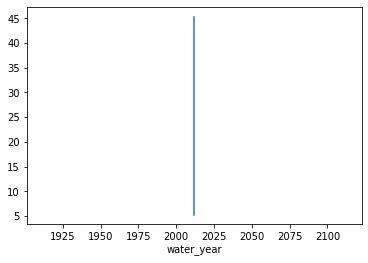

In [272]:
yr[0]['Aneroid Lake #2 (302) Precip (in)'].plot()

In [258]:
diff[0]

,Date,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in),Smith Ridge (1167) Precip (in),Milk Shakes (1079) Precip (in)
0,1 days,0.2,0.0,0.3,1.1,0.5
1,1 days,0.6,0.8,0.3,1.6,0.6
2,1 days,0.4,0.5,0.3,1.2,0.8
3,1 days,0.1,0.2,0.1,0.5,0.3
4,1 days,0.0,0.0,0.1,0.0,0.1
...,...,...,...,...,...,...
314,1 days,0.0,0.0,0.0,0.0,0.0
315,1 days,0.0,0.0,0.0,0.0,0.0
316,1 days,0.0,0.0,0.0,0.0,0.0
317,1 days,0.0,0.0,0.0,0.0,0.0


In [271]:
a = yr[0]['Date']


[water_year
 2012   2011-11-16
 2012   2011-11-17
 2012   2011-11-18
 2012   2011-11-19
 2012   2011-11-20
           ...    
 2012   2012-09-26
 2012   2012-09-27
 2012   2012-09-28
 2012   2012-09-29
 2012   2012-09-30
 Name: Date, Length: 320, dtype: datetime64[ns]]

In [255]:
cummulative_sum[0]

,Date,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in),Smith Ridge (1167) Precip (in),Milk Shakes (1079) Precip (in)
0,1 days,0.2,0.0,0.3,1.1,0.5
1,2 days,0.8,0.8,0.6,2.7,1.1
2,3 days,1.2,1.3,0.9,3.9,1.9
3,4 days,1.3,1.5,1.0,4.4,2.2
4,5 days,1.3,1.5,1.1,4.4,2.3
...,...,...,...,...,...,...
314,315 days,40.0,39.7,26.5,80.7,68.9
315,316 days,40.0,39.7,26.5,80.7,68.9
316,317 days,40.0,39.7,26.5,80.7,68.9
317,318 days,40.0,39.7,26.5,80.7,68.9


In [242]:
len(cummulative_sum[0])

319

##### Function pieces

In [ ]:
#Double Mass Analysis (combined years)
  # global a, b, c, d
  # a = pd.DataFrame(abs(df2.iloc[:,0].diff()))
  # b = pd.DataFrame(df2.iloc[:,0].cumsum())
  
  # x=pd.DataFrame(df2.iloc[:,0].diff().cumsum())
  # x.columns = ['x']
  # y=pd.DataFrame(np.add.reduce([df2.iloc[:,i].diff().cumsum() for i in range(0, len(args))]))  #might want to try to use pd.apply(np.cumsum) here to reduce to maintain datetime index
  
  # c = pd.DataFrame(np.add.reduce([df2.iloc[:,i].diff() for i in range(0, len(args))]))
  # d = y
  
  # return a, b, c, d


#   y.index = x.index
#   y.columns= ['y']

#   # delta = np.cumsum()
#   # def pos_diff_cum_sum(flow_in, flow_out):
#   #   delta = np.cumsum(flow_in - flow_out)
#   #   return delta ## - np.minimum.accumulate(np.append([0], delta))[1:]



# #Double Mass Analysis (separated years)


#   # # df2.columns = [f'{args[0]} SWE (in)', f'{args[1]} SWE (in)', f'{args[2]} SWE (in)']
#   # df2.columns = [f'{args[i]} SWE (in)' for i in range(0, len(args))]


  # df2.set_index('water_year')
  # years = list(range(int(df2.index[0].strftime("%Y")), int(df2.index[-1].strftime("%Y"))))
  # yr = [df2[str(years[i])] for i in range(0,len(years))]

  # # diff = [yr[i].apply(np.diff) for i in range(0,len(years))]
  # cummulative_sum = [yr[i].apply(np.cumsum) for i in range(0,len(years))]
  # x = [pd.DataFrame(cummulative_sum[i].iloc[:,0]) for i in range(0,len(years))]
  # y = [pd.DataFrame(np.sum(cummulative_sum[i], axis=1)) for i in range(0,len(years))]

  # for i in range(0,len(years)):
  #   y[i].columns = ['reduced_cumsum']

  # print(x)
  # print(y)




# #Run t test stat analysis with specified event_date as the middle between the two datasets

#   # df = pd.DataFrame(df2.iloc[:,0][len(df2.iloc[:,0]) - 2*len(df2.iloc[:,0][df2.iloc[:,0].index > event_date]):len(df2.iloc[:,0])])
#   # df = np.split(df,2)

#   # ttest = stats.ttest_ind(df[0], df[1])
#   # statistic = ttest[0]
#   # pvalue = ttest[1]
#   # print('Null hypothesis(H0: μ1=μ2). Alternative hypothesis(H1: μ1!=μ2.)')
#   # print(f'Calculated t test statistic: {statistic}.  Calculated p value: {pvalue}')
#   # if pvalue < 0.05:
#   #   print('The p value obtained from T-test analysis is significant (p value < 0.05), and therefore, we reject the H0 as there is a significant difference between means.')
#   # else:
#   #   print('The p value obtained from T-test analysis is not significant (p value > 0.05), and therefore, we fail to reject the H0 as there is not a significant difference between means.')

# #Plot the data

#   customdata_list = [df2.iloc[:,0], x, y]
#   customdata = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), customdata_list)
#   customdata.reset_index(inplace=True)
#   # print(customdata.iloc[:,0])
#   # fig = go.Figure()
#   fig = make_subplots(
#       rows=1, cols=2,
#       subplot_titles=(f'{parameter} Double Mass Curve', f'Yearly {parameter} Double Mass Curve')
#   )

#   fig.add_trace(go.Scatter(
#       x=x.iloc[:,0],
#       y=y.iloc[:,0],
#       mode='lines',
#       customdata=customdata,
#       hovertemplate = '<b>Date: %{customdata[0]}</b>', #<br>Site of Interest - Cumulative {parameter}: %{customdata[2]:.2f}</br>Comparison Site(s) - Cumulative SWE (in): %{customdata[3]:.2f}<br>Site of Interest - SWE (in): %{customdata[1]:.2f}</br>',
#       # hovertemplate = f'<b>Date: %{customdata.iloc[:,0]}</b><br>Site of Interest - Cumulative:  %{customdata.iloc[:,2]}</br>', #Comparison Site(s) - Cumulative {parameter}: {customdata[3]}<br>Site of Interest - Daily {parameter}: {customdata[1]}</br>',
#       name = 'Double mass curve'
#   ),
#       row=1, col=1
#   )


#   # site_list = [ORWA_Sites2[args[i]][parameter].dropna().resample(time_freq).sum() for i in range(0, len(args))] 
#   # df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), site_list).dropna()
#   # df2 = df_merged.resample(time_freq).sum()

#   # # df2.columns = [f'{args[0]} SWE (in)', f'{args[1]} SWE (in)', f'{args[2]} SWE (in)']
#   # df2.columns = [f'{args[i]} SWE (in)' for i in range(0, len(args))]

#   # years = list(range(int(df2.index[0].strftime("%Y")), int(df2.index[-1].strftime("%Y"))))
#   # yr = [df2[str(years[i])] for i in range(0,len(years))]

#   # # diff = [yr[i].apply(np.diff) for i in range(0,len(years))]
#   # cummulative_sum = [yr[i].apply(np.cumsum) for i in range(0,len(years))]
#   # x = [pd.DataFrame(cummulative_sum[i].iloc[:,0]) for i in range(0,len(years))]
#   # y = [pd.DataFrame(np.sum(cummulative_sum[i], axis=1)) for i in range(0,len(years))]

#   # for i in range(0,len(years)):
#   #   y[i].columns = ['reduced_cumsum']

#   # print(x)
#   # print(y)
#   # for i in range(0,len(years)):
#   #   fig.add_trace(go.Scatter(
#   #     x=x[i].iloc[:,0],
#   #     y=y[i].iloc[:,0],
#   #     mode='lines',
#   #     name=f'{x[i].index[0].strftime("%Y")}',
#   #     hovertext = x[i].index,
      
#   # ),
#   #     row=1, col=2
#   # )

#   # fig.update_xaxes(title_text= f"Cumulative {parameter} at {args[0]}", row=1, col=1)
#   # fig.update_xaxes(title_text=f"Cumulative {parameter} at {args[0]}", row=1, col=2)

#   # fig.update_yaxes(title_text=f"Total Cumulative {parameter} of Comparison Sites <br>{args[1::]}</br>", row=1, col=1)
#   # fig.update_yaxes(title_text= f"Total Cumulative {parameter} of Comparison Sites <br>{args[1::]}</br>", row=1, col=2)

#   # fig.update_layout(
#   #  height=800,
#   #  width=1200,
  
#   # )

#   fig.show()


### Double Mass Analysis for various sites

#### Fire: site burned entirely

In [281]:
double_mass5('Aneroid Lake #2 (302)', parameter='Precip (in)',num_of_stat = 5, month=0, time_freq = 'D') #Sasse Ridge (734)  	Aneroid Lake #2 (302)

parameter                          AirTemp (degF)  Precip (in)  SWE (in)
station               parameter                                         
Aneroid Lake #2 (302) Precip (in)        0.515664     1.000000  0.146092
Mt. Howard (653)      Precip (in)        0.527033     0.982378  0.123186
Bourne (361)          Precip (in)        0.470152     0.975265  0.195239
Smith Ridge (1167)    Precip (in)        0.492938     0.975109  0.240146
Milk Shakes (1079)    Precip (in)        0.508587     0.973808  0.225450


KeyError: ignored

In [226]:
x

[                                   0    1    2    3    ...   361   362   363   364
 Aneroid Lake #2 (302) Precip (in)  0.2  0.8  1.2  1.3  ...   NaN   NaN   NaN   NaN
 Aneroid Lake #2 (302) Precip (in)  0.0  0.0  0.0  0.0  ...  49.3  50.2  52.1   NaN
 Aneroid Lake #2 (302) Precip (in)  0.1  0.1  0.2  0.2  ...  38.5  38.5  39.0   NaN
 Aneroid Lake #2 (302) Precip (in)  0.0  0.0  0.0  0.0  ...  41.0  41.0  41.0   NaN
 Aneroid Lake #2 (302) Precip (in)  0.1  0.1  0.1  0.1  ...  45.1  45.1  45.1  45.1
 Aneroid Lake #2 (302) Precip (in)  0.1  0.1  0.1  0.1  ...  61.5  61.5  61.8   NaN
 Aneroid Lake #2 (302) Precip (in)  0.3  0.3  0.3  0.3  ...  42.5  42.5  42.5   NaN
 
 [7 rows x 365 columns]]

In [256]:
cummulative_sum[0]

,Date,Aneroid Lake #2 (302) Precip (in),Mt. Howard (653) Precip (in),Bourne (361) Precip (in),Smith Ridge (1167) Precip (in),Milk Shakes (1079) Precip (in)
0,1 days,0.2,0.0,0.3,1.1,0.5
1,2 days,0.8,0.8,0.6,2.7,1.1
2,3 days,1.2,1.3,0.9,3.9,1.9
3,4 days,1.3,1.5,1.0,4.4,2.2
4,5 days,1.3,1.5,1.1,4.4,2.3
...,...,...,...,...,...,...
314,315 days,40.0,39.7,26.5,80.7,68.9
315,316 days,40.0,39.7,26.5,80.7,68.9
316,317 days,40.0,39.7,26.5,80.7,68.9
317,318 days,40.0,39.7,26.5,80.7,68.9


In [176]:
df2.index

Int64Index([2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='water_year', length=2731)

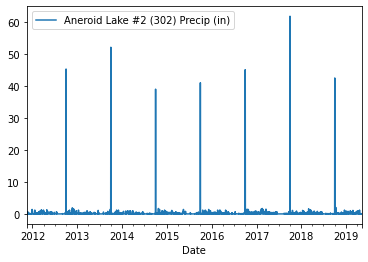

In [82]:
a.plot()

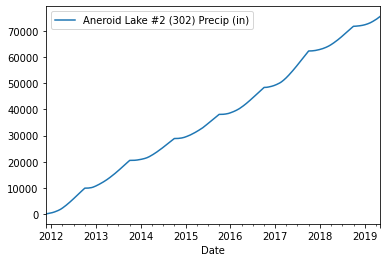

In [79]:
b.plot()

In [31]:
double_mass5('Corral Pass (418)', parameter='SWE (in)',num_of_stat = 4, month=0, time_freq = 'D') #Sasse Ridge (734)  'Corral Pass (418)'
#Corral Pass burned down in 2018

parameter                          AirTemp (degF)  Precip (in)  SWE (in)
station                 parameter                                       
Corral Pass (418)       SWE (in)        -0.402218     0.241632  1.000000
Pigtail Peak (692)      SWE (in)        -0.381161     0.260293  0.983077
Mt Hood Test Site (651) SWE (in)        -0.396317     0.239370  0.969695
MF Nooksack (1011)      SWE (in)        -0.317822     0.272582  0.966687


In [ ]:
double_mass5('Diamond Lake (442)', parameter = 'Precip (in)', num_of_stat=4, month=0, time_freq = 'D')  #'Annie Springs (1000)'

In [ ]:
double_mass5('Annie Springs (1000)', parameter = 'Precip (in)', num_of_stat=4, month=0, time_freq = 'D')  #'Annie Springs (1000)'

In [ ]:
double_mass4('Corral Pass (418)', 'Huckleberry Creek (928)', 'Morse Lake (642)',parameter='Precip (in)',month=0, time_freq = 'D')
#Corral Pass burned down in 2018

In [ ]:
double_mass4('Diamond Lake (442)', 'Summit Lake (801)', parameter='Precip (in)', month=0, time_freq = 'D')  #'Annie Springs (1000)'
#Burnt down sometime in late summer fires of 2020.

#### Fire nearby, but site remained intact

In [ ]:
double_mass4('Moses Mtn (644)', 'Sentinel Butte (1043)', parameter = 'Precip (in)', month=0, time_freq = 'D')
#Installed snow pillow on 9/4/2003 at Sentinel Butte.
#Moses installed 2003/4

In [ ]:
double_mass4('Sasse Ridge (734)', 'Fish Lake (478)','Olallie Meadows (672)','Stampede Pass (788)', parameter= "SWE (in)", month=0, time_freq = 'D')

In [ ]:
double_mass4('Sentinel Butte (1043)', 'Moses Mtn (644)',month=0, parameter="SWE (in)", time_freq = 'D') #, 'Bunchgrass Mdw (376)'

In [ ]:
double_mass4('Mckenzie (619)', 'Bear Grass (1166)', 'Hogg Pass (526)', parameter='SWE (in)', month=0, time_freq = 'D') #, 'Bunchgrass Mdw (376)'
#nothing obvious is sitevisit log that would indicate a reason for the data to change in 2012 at McKenzie, Bear Grass, or Hogg Pass
#Bear was installed Sep 2011

#### Pillow Alterations

In [ ]:
double_mass4('Roaring River (719)', 'Irish Taylor (545)', 'Cascade Summit (388)', month=0, parameter='SWE (in)', time_freq='D')

In [ ]:
double_mass4('Railroad Overpass (710)', 'Salt Creek Falls (729)', month=0, parameter='SWE (in)', time_freq='D')  #'Holland Meadows (529)', 'Cascade Summit (388)'

In [ ]:
double_mass4('Mud Ridge (655)', 'Clear Lake (401)','Red Hill (712)', time_freq='D', parameter='AirTemp (degF)', month=0) #'Clackamas Lake (398)', 'Mt Hood Test Site (651)'

## Scratch pad code

In [ ]:
#Adding water year index

# pd.to_datetime(df2.index)
# df2['water_year'] = df2.index.dt.year.where(df2.index.dt.month < 10, df2.index.dt.year + 1)
 
#Even though the index is already set as datetime, regular datetime objects have different methods than datetimeindexes.  So...
#we have to reset the index so the dates become just a regular datetime object which then we can use the .dt.year methods with.
#Having an argument as a datetime is apparently different than a datetimeindex...super confusing. 
# df2.reset_index(inplace=True) 
pd.to_datetime(df2['Date'])
df2['water_year'] = df2['Date'].dt.year.where(df2['Date'].dt.month < 10, df2['Date'].dt.year + 1)
df2.insert(1, 'water_year', df2.pop('water_year'))

# df2[df2['Aneroid Lake #2 (302) Precip (in)'].index > '2011-10-01' and df2['Aneroid Lake #2 (302) Precip (in)'].index < '2012-10-31']

#### Prep'ing data for statistical tests

In [ ]:
# site_list2 = []
#     for i in range(0, len(site_list)):
#       site_list2.append(ORWA_Sites[site_list[i]].dropna())

event_date = '2019-03-01'

site_list = ('Moses Mtn (644)', 'Sentinel Butte (1043)','Annie Springs (1000)')
site_list2 = []
for i in range(0, len(site_list)):
  site_list2.append(ORWA_Sites[site_list[i]].dropna())

# site_list2
x=site_list2[0]
y=(np.add.reduce(site_list2))
x1=site_list2[0].cumsum()
y1=(np.add.reduce(site_list2)).cumsum()

df = x[len(x) - 2*len(x[x.index > event_date]):len(x)]
df1 = y[len(y) - 2*len(y[y.index > event_date]):len(y)]

df = np.split(df,2)
df1 = np.split(df1,2)

fvalue, pvalue = stats.f_oneway(df[0], df[1])
fvalue1, pvalue1 = stats.f_oneway(df1[0], df1[1])
print(fvalue, pvalue)
print(fvalue1, pvalue1)
print(df[0].describe())
pd.DataFrame(df[0]).boxplot()
print(df[1].describe())
pd.DataFrame(df[1]).boxplot()

KeyError: ignored

#### Reducing for year and month scales

In [ ]:
def double_mass(*args, month, scale):  #If you set month to a default, python sees it as a key-value argument which won't make *args work.
  
  if scale = year:
    np.reduce



  site_list = args

  if month == 0:
    site_list2 = []
    for i in range(0, len(site_list)):
      site_list2.append(ORWA_Sites[site_list[i]].dropna())

  elif month > 0 or month < 12:
    site_list1 = []
    for i in range(0, len(site_list)):
      site_list1.append(ORWA_Sites[site_list[i]].dropna())
      
    site_list2 = []
    for j in range(0, len(site_list)):
      site_list2.append(site_list1[j][site_list1[j].index.month==month])
  
  else:
    print('select month (1-12)')


  x=site_list2[0].cumsum()
  y=(np.add.reduce(site_list2)).cumsum()

  # res = sm.OLS(y, x).fit().fittedvalues
  # print(res)

  customdata = pd.DataFrame(zip(site_list2[0].reset_index()['Date'], x, y)) #Can also use np.c_
  
    
  fig = go.Figure()
  
  fig.add_trace(go.Scatter(
      x=x,
      y=y,
      mode='lines',
      customdata=customdata,
      hovertemplate = 'Date: <b>%{customdata[0]}</b><br> x-Axis Accumulative SWE (in): %{customdata[1]}</br><br> y-Axis Accumulative SWE (in): %{customdata[2]}</br>',
      name = 'Site of interest: {}'.format(site_list2[0].name)
  ))

  fig.update_layout(
   height=900,
   width=900,
   title={
        'text': 'SWE Double Mass Analysis',
        'y':.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Accumulative SWE at site of interest (%s)" % (site_list2[0].name),
    yaxis_title="Total Accumulative SWE of all Comparison Sites %s" % ([site_list2[i].name for i in range(0, len(site_list2))]),
        
        
        # site_list2[i].name, site_list2[2].name),
    xaxis2=dict(title='Date',
                overlaying='y',
                side='right')   
  )

  fig.show()
  # print(site for site.name in site_list2)


SyntaxError: ignored

In [ ]:
print(x[x.index==event_date])
print(y[y.index==event_date])

In [ ]:
len(x1)

In [ ]:
len(x[x.index>event_date])

In [ ]:
df = ORWA_Sites['Moses Mtn (644)'].iloc[:-3].dropna()


In [ ]:
df

In [ ]:
len(df)

In [ ]:
a = np.split(df, 2)

In [ ]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(a[0], a[1])
print(fvalue, pvalue) #can't use cumulative in actual analysis as there will be obvious significant differences.

In [ ]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # perform multiple pairwise comparison (Tukey HSD)
# m_comp = pairwise_tukeyhsd(endog=a[1], groups=a[0], alpha=0.05)
# print(m_comp)

In [ ]:
# def bla(date, station of interest, comparison stations):

#   run corr bw x and y before date and after the date

#   run anova for x before the date and after the date
